**FIRST ATTEMP TO APPLY SSL TO THE SENTINEL-2 DATASET**

Reference tutorial: https://docs.lightly.ai/tutorials/package/tutorial_simsiam_esa.html

In [1]:
def is_notebook() -> bool:
    try:
        shell = get_ipython().__class__.__name__

        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)

    except NameError:
        return False      # Probably standard Python interpreter

In [2]:
# if is_notebook():
#     %load_ext pycodestyle_magic

In [3]:
# if is_notebook():
#     %pycodestyle_on

In [4]:
# def create_arg_parser():
#     """Creates and returns the ArgumentParser object."""
#     ...
#     return parser

***

***

# Initial configuration

## Libraries and modules

In [5]:
# Custom modules.
from utils.computation import Experiment, pca_computation, tsne_computation
from utils.dataset import load_dataset_based_on_ratio, GaussianBlur
from utils.graphs import simple_bar_plot
from utils.models import SimSiam, SimCLRModel, BarlowTwins

# OS module.
import os

# PyTorch.
import torch
import torchvision
from torchvision import transforms
from torchinfo import summary

# Data management.
import numpy as np
import pandas as pd

# Lightly.
import lightly

# Training checks.
from datetime import datetime
import time
import copy
import math
from lightly.utils.debug import std_of_l2_normalized

# Showing images in the notebook.
import IPython

# For plotting.
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.offsetbox as osb
from matplotlib import rcParams as rcp
import seaborn as sns
import plotly.express as px

# For resizing images to thumbnails.
import torchvision.transforms.functional as functional

# For clustering and 2d representations.
from sklearn import random_projection

# Argparse
import sys
import argparse

In [6]:
import matplotlib.font_manager

## Parser

In [7]:
# Parser (get arguments).
parser = argparse.ArgumentParser(
    description="Script for training the self-supervised learning models."
)

parser.add_argument(
    'model',
    type=str,
    choices=['simsiam', 'simclr', 'barlowtwins'],
    help=('SSL model for training. '
          "Use 'simsiam', 'simclr' or 'barlowtwins'.")
)
parser.add_argument(
    '--dataset',
    type=str,
    default='Sentinel2GlobalLULC_SSL',
    help='dataset name for training.'
)
parser.add_argument(
    '--ratio',
    type=str,
    default='(0.900,0.0250,0.0750)',
    help='dataset ratio for evaluation.'
)
parser.add_argument(
    '--epochs',
    type=int,
    default=25,
    help='number of epochs for training.'
)
parser.add_argument(
    '--batch_size',
    type=int,
    default=64,
    help='number of images in a batch during training.'
)
parser.add_argument(
    '--ini_weights',
    type=str,
    default='random',
    choices=['random', 'imagenet'],
    help="initial weights: use 'random' (default) or 'imagenet'."
)
parser.add_argument(
    '--balanced_dataset',
    action='store_true',
    help='whether the dataset should be balanced.'
)
parser.add_argument(
    '--show_fig',
    action='store_true',
    help='whether the images should appear.'
)
parser.add_argument(
    '--cluster',
    action='store_true',
    help=('whether the script runs on a cluster '
          '(large memory space available).')
)

if is_notebook():
    args = parser.parse_args(
        args=['simclr',
              '--balanced_dataset',
              '--show_fig',
              '--dataset', 'Sentinel2GlobalLULC_SSL',
              '--epochs', '5',
              '--ratio', '(0.900,0.0250,0.0750)'])
else:
    args = parser.parse_args(sys.argv[1:])

## Settings and options

In [8]:
# Target SSL model.
model_name = args.model
print(f'\nTarget model for training:\t{model_name}')

# Target dataset name.
dataset_name = args.dataset
print(f'Target dataset name:\t\t{dataset_name}')

# Target dataset ratio.
dataset_ratio = args.ratio
print(f'Target dataset ratio:\t\t{dataset_ratio}')

# Handling class imbalance.
handle_imb_classes = args.balanced_dataset
print(f'Balanced dataset:\t\t{handle_imb_classes}')

# Setting number of epochs.
epochs = args.epochs
print(f'Number of epochs:\t\t{epochs}')

# Setting batch size.
batch_size = args.batch_size
print(f'Batch size:\t\t\t{batch_size}')

# Setting the initial weights.
if args.ini_weights == 'imagenet':
    weights = torchvision.models.ResNet18_Weights.DEFAULT
else:
    weights = None
print(f'Initial weights:\t\t{weights}')

# Show figures.
show = args.show_fig
print(f'Showing figures:\t\t{show}')

# Supercomputer?
cluster = args.cluster
print(f'Execution on cluster:\t\t{cluster}')

# Avoiding the runtimeError: Too many open files.
# Communication with the workers is no longer possible.
if is_notebook() or cluster:
    print('  - Torch sharing strategy set to file_system (default)')
    torch.multiprocessing.set_sharing_strategy('file_descriptor')
else:
    print('  - Torch sharing strategy set to file_system (less memory)')
    torch.multiprocessing.set_sharing_strategy('file_system')


Target model for training:	simclr
Target dataset name:		Sentinel2GlobalLULC_SSL
Target dataset ratio:		(0.900,0.0250,0.0750)
Balanced dataset:		True
Number of epochs:		5
Batch size:			64
Initial weights:		None
Showing figures:		True
Execution on cluster:		False
  - Torch sharing strategy set to file_system (default)


In [9]:
# Hyperparamenters.
exp = Experiment(epochs=epochs,
                 batch_size=batch_size)
print(f'\nDevice: {exp.device}')

# Get current directory.
cwd = os.getcwd()
print(f'\nWorking directory:\t\t\t{cwd}')

# Input path where the datasets are stored.
input_path_datasets = os.path.join(cwd, 'datasets')
print(f'Input path for datasets:\t\t{input_path_datasets}')

# Output path.
output_path = os.path.join(cwd, 'output')

# Output path to save the model checkpoint.
output_path_models = os.path.join(os.path.join(output_path, 'pytorch_models'),
                                 model_name)
print(f'Output path for model checkpoints:\t{output_path_models}')

# Folder to save the figures.
output_path_figs = os.path.join(os.path.join(output_path, 'figures'),
                               model_name)
fig_format = '.png'  # .pdf
print(f'Output path for figures ({fig_format}):\t\t{output_path_figs}')


Device: cuda

Working directory:			/home/sfandres/Documents/Git/lulc
Input path for datasets:		/home/sfandres/Documents/Git/lulc/datasets
Output path for model checkpoints:	/home/sfandres/Documents/Git/lulc/output/pytorch_models/simclr
Output path for figures (.png):		/home/sfandres/Documents/Git/lulc/output/figures/simclr


In [10]:
# Dimension of the embeddings.
num_ftrs = 512

# Dimension of the output of the prediction and projection heads.
out_dim = proj_hidden_dim = 512

# The prediction head uses a bottleneck architecture.
pred_hidden_dim = 128

## Reproducibility

In [11]:
exp.reproducibility()

***

***

# Dataset

## Load normalization values

In [12]:
# Retrieve the mean and std values of each split from
# a .txt file previously generated using a custom script.
data_path_target, mean, std = load_dataset_based_on_ratio(
    input_path_datasets,
    dataset_name,
    dataset_ratio
)

Path to dataset folder: /home/sfandres/Documents/Git/lulc/datasets/Sentinel2GlobalLULC_SSL
Dataset found based on the given ratio: True

Path to split folder: /home/sfandres/Documents/Git/lulc/datasets/Sentinel2GlobalLULC_SSL/Sentinel2GlobalLULC-ratio=(0.900,0.0250,0.0750)-seed=42
Mean loaded from .txt: {'train': [0.3328, 0.3372, 0.3602], 'val': [0.3332, 0.3381, 0.361], 'test': [0.3323, 0.337, 0.3602]}
Std loaded from .txt:  {'train': [0.2978, 0.2377, 0.2115], 'val': [0.2974, 0.239, 0.2129], 'test': [0.2972, 0.2371, 0.2113]}


## Custom transforms

Define the augmentations for self-supervised learning.

In [13]:
splits = ['train', 'val', 'test']

# Normalization transform (val and test).
transform = {x: transforms.Compose([
    transforms.Resize((exp.input_size, exp.input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean[x],
                         std=std[x])
]) for x in splits[1:]}

# Normalization transform (train).
# from https://github.com/facebookresearch/simsiam/blob/main/main_simsiam.py
# MoCo v2's aug: similar to SimCLR https://arxiv.org/abs/2002.05709
transform['train'] = transforms.Compose([
    transforms.Resize((exp.input_size, exp.input_size)),
    transforms.RandomResizedCrop(224, scale=(0.2, 1.)),
    transforms.RandomApply([
        transforms.ColorJitter(.4, .4, .4, .1)  # not strengthened
    ], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomApply([GaussianBlur([.1, 2.])], p=0.5),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean['train'],
                         std['train'])
])

for t in transform:
    print(f'\n{t}: {transform[t]}')


val: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.3332, 0.3381, 0.361], std=[0.2974, 0.239, 0.2129])
)

test: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.3323, 0.337, 0.3602], std=[0.2972, 0.2371, 0.2113])
)

train: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    RandomResizedCrop(size=(224, 224), scale=(0.2, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear), antialias=None)
    RandomApply(
    p=0.8
    ColorJitter(brightness=[0.6, 1.4], contrast=[0.6, 1.4], saturation=[0.6, 1.4], hue=[-0.1, 0.1])
)
    RandomGrayscale(p=0.2)
    RandomApply(
    p=0.5
)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.3328, 0.3372, 0.3602], std=[0.2978, 0.2377, 0.2115])
)


## ImageFolder

In [14]:
# Loading the three datasets with ImageFolder.
dataset = {x: torchvision.datasets.ImageFolder(
    os.path.join(data_path_target, x)) for x in splits}

for d in dataset:
    print(f'\n{d}: {dataset[d]}')


train: Dataset ImageFolder
    Number of datapoints: 175381
    Root location: /home/sfandres/Documents/Git/lulc/datasets/Sentinel2GlobalLULC_SSL/Sentinel2GlobalLULC-ratio=(0.900,0.0250,0.0750)-seed=42/train

val: Dataset ImageFolder
    Number of datapoints: 4861
    Root location: /home/sfandres/Documents/Git/lulc/datasets/Sentinel2GlobalLULC_SSL/Sentinel2GlobalLULC-ratio=(0.900,0.0250,0.0750)-seed=42/val

test: Dataset ImageFolder
    Number of datapoints: 14635
    Root location: /home/sfandres/Documents/Git/lulc/datasets/Sentinel2GlobalLULC_SSL/Sentinel2GlobalLULC-ratio=(0.900,0.0250,0.0750)-seed=42/test


## Dealing with imbalanced data

In [15]:
if handle_imb_classes:

    # Creating a list of labels of samples.
    train_sample_labels = dataset['train'].targets

    # Calculating the number of samples per label/class.
    class_sample_count = np.unique(train_sample_labels,
                                   return_counts=True)[1]
    print(class_sample_count)

    # Weight per sample not per class.
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in train_sample_labels])

    # Casting.
    samples_weight = torch.from_numpy(samples_weight)
    samples_weigth = samples_weight.double()

    # Sampler, imbalanced data.
    sampler = torch.utils.data.WeightedRandomSampler(
        samples_weight,
        len(samples_weight)
    )
    shuffle = False

else:
    sampler = None
    shuffle = True

print(f'\nSampler:\t{sampler}')
print(f'Shuffle:\t{shuffle}')

[ 5742  2592   510  1132 12600  3522  3484 12591   374   438 12600  3784
 12600 12600 12600  1803   757   918   317   371 11331  4190  7982 12600
 10743  3993  1213 12600  9394]

Sampler:	<torch.utils.data.sampler.WeightedRandomSampler object at 0x7f24321638b0>
Shuffle:	False


## Cast to Lightly dataset

In [16]:
# Builds a LightlyDataset from a PyTorch (or torchvision) dataset.
# Returns a tuple (sample, target, fname) when accessed using __getitem__.
lightly_dataset = {x: lightly.data.LightlyDataset.from_torch_dataset(
    dataset[x]) for x in splits}

print()
for d in lightly_dataset:
    print(f'{d}:\t{lightly_dataset[d]}')

# test_data_lightly = lightly.data.LightlyDataset.from_torch_dataset(
#     test_data,
#     transform=test_transform
# )


train:	<lightly.data.dataset.LightlyDataset object at 0x7f2431f63340>
val:	<lightly.data.dataset.LightlyDataset object at 0x7f2431f610f0>
test:	<lightly.data.dataset.LightlyDataset object at 0x7f2431f61c30>


## Collate functions

PyTorch uses a Collate Function to combine the data in your batches together.

BaseCollateFunction (base class) takes a batch of images as input and <b>transforms each image into two different augmentations</b> with the help of random transforms. The images are then concatenated such that the output batch is exactly twice the length of the input batch.

In [17]:
# Base class for other collate implementations.
# This allows training.
collate_fn = {x: lightly.data.collate.BaseCollateFunction(
    transform[x]) for x in splits}

print()
for c in collate_fn:
    print(f'{c}:\t{collate_fn[c]}')


train:	BaseCollateFunction()
val:	BaseCollateFunction()
test:	BaseCollateFunction()


**Important note:** These functions could be removed if I implement a custom load dataset with a get_item that gets and tranforms two batches of images.

## PyTorch dataloaders

In [18]:
# # Dataloader for embedding (test).
# dataloader_test = torch.utils.data.DataLoader(
#     test_data_lightly,
#     batch_size=exp.batch_size,
#     shuffle=False,
#     drop_last=False,
#     num_workers=exp.num_workers,
#     worker_init_fn=exp.seed_worker,
#     generator=exp.g
# )

# Dataloader for validating and testing.
dataloader = {x: torch.utils.data.DataLoader(
    lightly_dataset[x],
    batch_size=exp.batch_size,
    shuffle=False,
    num_workers=exp.num_workers,
    collate_fn=collate_fn[x],
    drop_last=False,
    worker_init_fn=exp.seed_worker,
    generator=exp.g
) for x in splits[1:]}

# Dataloader for training.
dataloader['train'] = torch.utils.data.DataLoader(
    lightly_dataset['train'],
    batch_size=exp.batch_size,
    shuffle=shuffle,
    sampler=sampler,
    num_workers=exp.num_workers,
    collate_fn=collate_fn['train'],
    drop_last=False,
    worker_init_fn=exp.seed_worker,
    generator=exp.g
)

# Check if shuffle is enabled.
if isinstance(dataloader['train'].sampler, torch.utils.data.RandomSampler):
    print('\nShuffle is enabled in training')
else:
    print('\nShuffle is disabled in training')

for d in dataloader:
    print(f"\n{d}:\t{vars(dataloader[d])}")


Shuffle is disabled in training

val:	{'dataset': <lightly.data.dataset.LightlyDataset object at 0x7f2431f610f0>, 'num_workers': 0, 'prefetch_factor': 2, 'pin_memory': False, 'pin_memory_device': '', 'timeout': 0, 'worker_init_fn': <bound method Experiment.seed_worker of <utils.computation.Experiment object at 0x7f2504601840>>, '_DataLoader__multiprocessing_context': None, '_dataset_kind': 0, 'batch_size': 64, 'drop_last': False, 'sampler': <torch.utils.data.sampler.SequentialSampler object at 0x7f2431f62c80>, 'batch_sampler': <torch.utils.data.sampler.BatchSampler object at 0x7f2431f62290>, 'generator': <torch._C.Generator object at 0x7f2432170b70>, 'collate_fn': BaseCollateFunction(), 'persistent_workers': False, '_DataLoader__initialized': True, '_IterableDataset_len_called': None, '_iterator': None}

test:	{'dataset': <lightly.data.dataset.LightlyDataset object at 0x7f2431f61c30>, 'num_workers': 0, 'prefetch_factor': 2, 'pin_memory': False, 'pin_memory_device': '', 'timeout': 0, '

## Check the balance and size of the dataset

In [19]:
# Check samples per class, total samples and batches of each dataset.
for d in dataset:
    samples = np.unique(dataset[d].targets, return_counts=True)[1]
    print(f'\n{d}:')
    print(f'  - #Samples/class: {samples}')
    print(f'  - #Samples: {len(dataset[d].targets)}')
    print(f'  - #Batches: {len(dataloader[d])}')


train:
  - #Samples/class: [ 5742  2592   510  1132 12600  3522  3484 12591   374   438 12600  3784
 12600 12600 12600  1803   757   918   317   371 11331  4190  7982 12600
 10743  3993  1213 12600  9394]
  - #Samples: 175381
  - #Batches: 2741

val:
  - #Samples/class: [159  72  14  31 350  97  96 349  10  12 350 105 350 350 350  50  21  25
   8  10 314 116 221 350 298 110  33 350 260]
  - #Samples: 4861
  - #Batches: 76

test:
  - #Samples/class: [ 479  216   43   95 1050  295  292 1051   32   37 1050  316 1050 1050
 1050  151   64   77   28   32  945  350  666 1050  896  334  102 1050
  784]
  - #Samples: 14635
  - #Batches: 229


## Check the distribution of samples in the dataloader (lightly dataset)


Sample distribution computation in train dataset (s): 1477.49


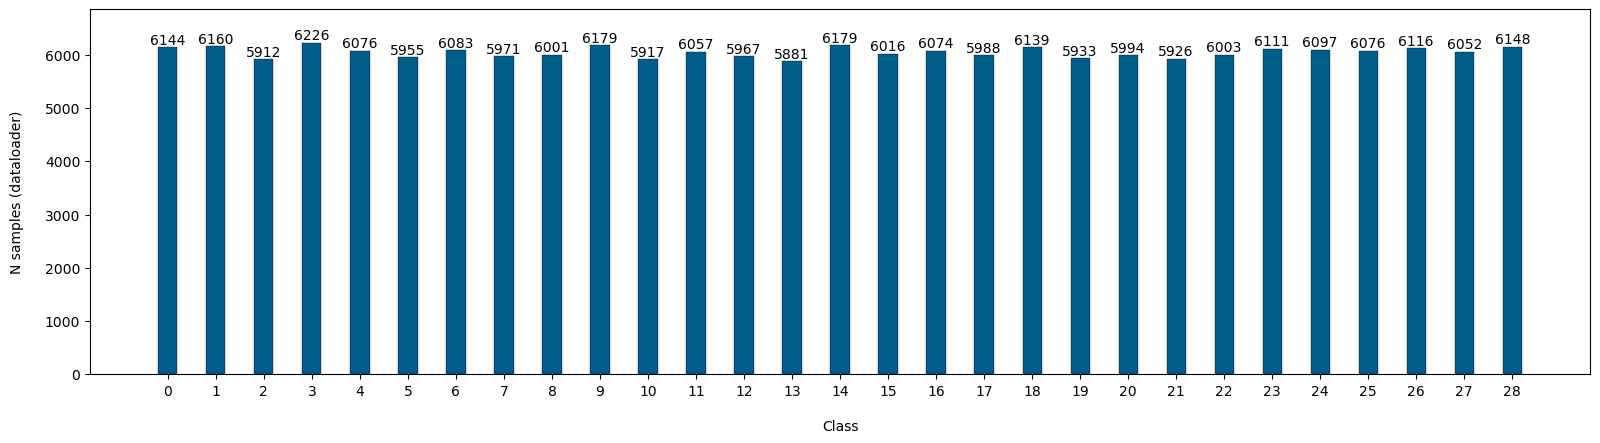

In [20]:
# List to save the labels.
labels_list = []

# Accessing Data and Targets in a PyTorch DataLoader.
t0 = time.time()
for i, (images, labels, names) in enumerate(dataloader['train']):
    labels_list.append(labels)

# Concatenate list of lists (batches).
labels_list = torch.cat(labels_list, dim=0).numpy()
print(f'\nSample distribution computation in train dataset (s): '
      f'{(time.time()-t0):.2f}')

# Count number of unique values.
data_x, data_y = np.unique(labels_list, return_counts=True)

# New function to plot (suitable for execution in shell).
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
simple_bar_plot(ax,
                data_x,
                'Class',
                data_y,
                'N samples (dataloader)')

plt.gcf().subplots_adjust(bottom=0.15)
plt.gcf().subplots_adjust(left=0.15)
fig_name_save = (f'sample_distribution'
                 f'-ratio={dataset_ratio}'
                 f'-balanced={handle_imb_classes}')
fig.savefig(os.path.join(output_path_figs, fig_name_save+fig_format),
            bbox_inches='tight')

plt.show() if show else plt.close()

## Look at some samples (lightly dataset)

### Only one sample from the training batch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 3, 224, 224])
torch.Size([64])


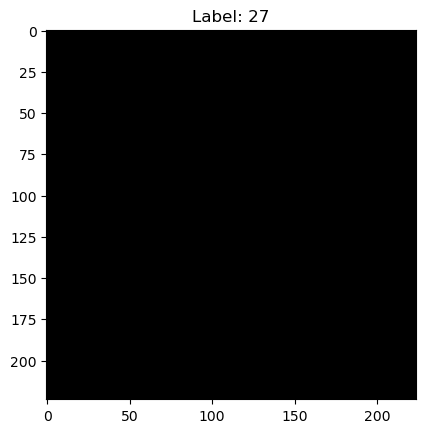

In [21]:
# Accessing Data and Targets in a PyTorch DataLoader.
for i, (images, labels, names) in enumerate(dataloader['train']):
    img = images[0][0]
    label = labels[0]
    print(images[0].shape)
    print(labels.shape)
    plt.title("Label: " + str(int(label)))
    plt.imshow(torch.permute(img, (1, 2, 0)))
    if show:
        plt.show()
    else:
        plt.close()
    if i == 0:
        break  # Only a few batches.

### Two batches (almost)

Note: Comment out the normalization augmentation first to view the images below properly.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

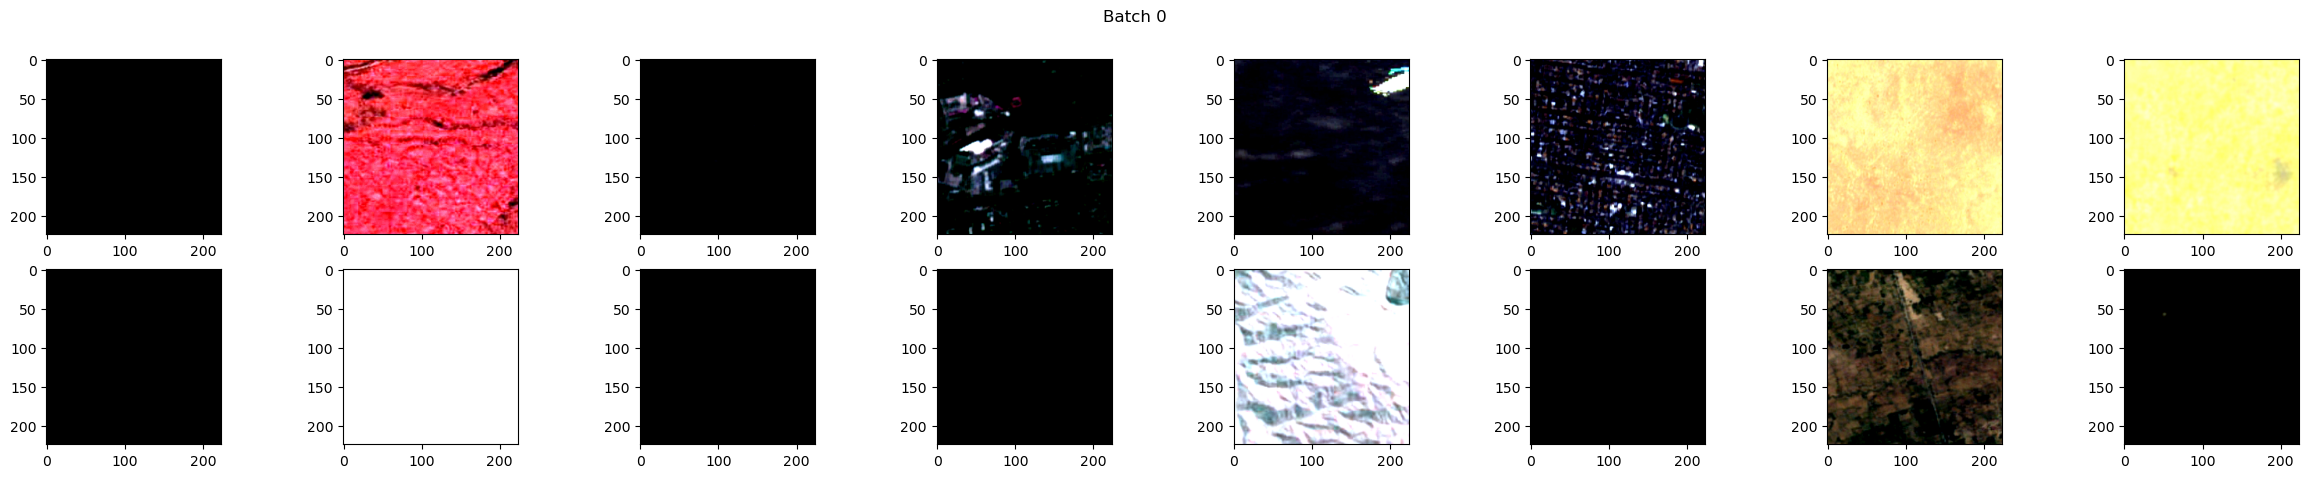

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

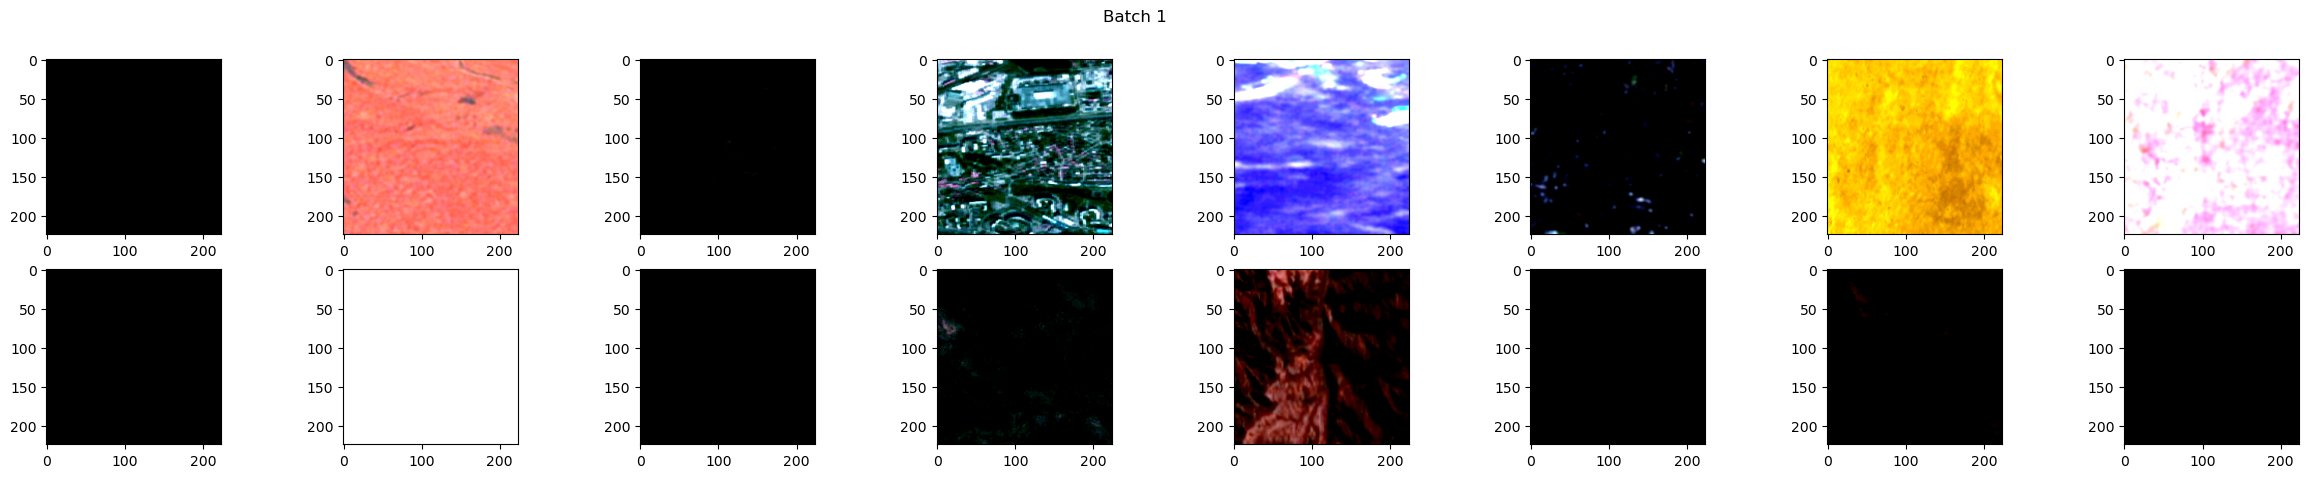

In [22]:
def show_batch(batch, batch_id):
    """
    Shows the images in the batch.

    Attributes:
        batch: Batch of images.
        batch_id: Batch identification number.
    """

    columns = 8
    rows = 2
    width = 30
    height = 5

    fig = plt.figure(figsize=(width, height))
    fig.suptitle(f'Batch {batch_id}')
    for i in range(1, columns * rows + 1):
        if i < exp.batch_size:
            img = batch[i]
            fig.add_subplot(rows, columns, i)
            plt.imshow(torch.permute(img, (1, 2, 0)))
    
    plt.show() if show else plt.close()


# Train loop.
for b, ((x0, x1), _, _) in enumerate(dataloader['train']):

    # Show the images within the first batch.
    show_batch(x0, 0)
    show_batch(x1, 1)
    break

Each image is augmented differently in the two batches that are loaded at the same time during training. The dataloader from lightly is capable of providing two batches in one iteration.

***

***

# Self-supervised models

<p style="color:red"><b>----> REVISED UP TO THIS POINT!</b></p>

## Creation

Reference: Lightly tutorials

## Backbone net (w/ ResNet18)

This is different from the tutorial: resnet without pretrained weights (not now).

In [ ]:
# Resnet trained from scratch.
resnet = torchvision.models.resnet18(
    weights=weights
)

# Removing head from resnet. Embedding.
backbone = torch.nn.Sequential(*list(resnet.children())[:-1])

# Model creation.
if model_name == 'simsiam':
    model = SimSiam(backbone, num_ftrs, proj_hidden_dim,
                    pred_hidden_dim, out_dim)
elif model_name == 'simclr':
    hidden_dim = resnet.fc.in_features
    model = SimCLRModel(backbone, hidden_dim)
elif model_name == 'barlowtwins':
    model = BarlowTwins(backbone)

In [ ]:
# Model's backbone structure.
summary(
    model.backbone,
    input_size=(exp.batch_size, 3, exp.input_size, exp.input_size),
    device=exp.device
)

## Training setup

SimSiam uses a symmetric negative cosine similarity loss and does therefore not require any negative samples. We build a criterion and an optimizer.



In [ ]:
if model_name == 'simsiam':
    model.set_up_optimizer_and_scheduler(exp.epochs,
                                         exp.batch_size)
    print(model.optimizer)
    print(model.scheduler)

elif model_name == 'simclr':
    model.set_up_optimizer_and_scheduler(exp.epochs,
                                         exp.batch_size)
    print(model.optimizer)
    print(model.warmup_scheduler)
    print(model.main_scheduler)

elif model_name == 'barlowtwins':
    model.configure_optimizer(exp.batch_size)
    model.configure_scheduler(exp.epochs,
                              exp.batch_size)
    print(model.optimizer)
    print(model.warmup_scheduler)
    print(model.main_scheduler)

else:
    # Scale the learning rate.
    # lr = 0.05 * exp.batch_size / 256
    lr = 0.2

    # Use SGD with momentum and weight decay.
    optimizer = torch.optim.SGD(
        model.parameters(),
        lr=lr,
        momentum=0.9,
        weight_decay=1e-4
    )

## Training

### Loop

In [ ]:
# def get_lr(optimizer):
#     for param_group in optimizer.param_groups:
#         return param_group['lr']

In [ ]:
# Device used for training.
print(f'\nUsing {exp.device} device')
model.to(exp.device)

# Saving best model's weights.
# best_model_wts = copy.deepcopy(model.state_dict())
collapse_level = 0.
lowest_train_loss = 10000
lowest_val_loss = 10000
total_train_batches = len(dataloader_train_lightly)
total_val_batches = len(dataloader_val_lightly)
print(f'\nBatches in (train, val) datasets: ({total_train_batches}, '
      f'{total_val_batches})\n')

# ======================
# TRAINING LOOP.
# Iterating over the epochs.
for e in range(exp.epochs):

    # Timer added.
    t0 = time.time()

    # Training enabled.
    model.train()

    # ======================
    # TRAINING COMPUTATION.
    # Iterating through the dataloader (lightly dataset is different).
    running_train_loss = 0.
    for b, ((x0, x1), _, _) in enumerate(dataloader_train_lightly):

        # Move images to the GPU (same batch two transformations).
        x0 = x0.to(exp.device)
        x1 = x1.to(exp.device)

        # Run the model on both transforms of the images:
        # We get projections (z0 and z1) and
        # predictions (p0 and p1) as output.
        if model_name == 'simsiam':
            z0, p0 = model(x0)
            z1, p1 = model(x1)
            loss = 0.5 * (model.criterion(z0, p1) + model.criterion(z1, p0))
        else:
            loss = model.training_step(x0, x1)

        # Averaged loss across all training examples * batch_size.
        running_train_loss += loss.item() * exp.batch_size

        # Run backpropagation.
        loss.backward()
        
        if model_name == 'simsiam' or model_name == 'simclr' or model_name == 'barlowtwins':
            model.optimizer.step()
            model.optimizer.zero_grad()
        else:
            optimizer.step()
            optimizer.zero_grad()

        if model_name == 'simsiam':
            model.check_collapse(p0, loss)

        # Show partial stats.
        if b % (total_train_batches//4) == (total_train_batches//4-1):
            print(f'T[{e}, {b + 1:5d}] | '
                  f'Running train loss: '
                  f'{running_train_loss/(b*exp.batch_size):.4f}')

    # The level of collapse is large if the standard deviation of
    # the l2 normalized output is much smaller than 1 / sqrt(dim).
    if model_name == 'simsiam':
        collapse_level = max(0., 1 - math.sqrt(out_dim) * model.avg_output_std)

    # ======================
    # TRAINING LOSS.
    # Loss averaged across all training examples for the current epoch.
    epoch_train_loss = (running_train_loss
                        / len(dataloader_train_lightly.sampler))

    # ======================
    # EVALUATION COMPUTATION.
    # The evaluation process was not okey (it's been deleted).
    model.eval()
    running_val_loss = 0.
    with torch.no_grad():
        for vb, ((x0, x1), y, _) in enumerate(dataloader_val_lightly):

            # Move images to the GPU (same batch two transformations).
            x0 = x0.to(exp.device)
            x1 = x1.to(exp.device)

            # Compute loss
            if model_name == 'simsiam':
                z0, p0 = model(x0)
                z1, p1 = model(x1)
                loss = .5 * (model.criterion(z0, p1) + model.criterion(z1, p0))
            else:
                loss = model.training_step(x0, x1)

            # Averaged loss across all validation examples * batch_size.
            running_val_loss += loss.item() * exp.batch_size

            # Show partial stats.
            if vb % (total_val_batches//4) == (total_val_batches//4-1):
                print(f'V[{e}, {vb + 1:5d}] | '
                      f'Running val loss: '
                      f'{running_val_loss/(vb*exp.batch_size):.4f}')

    model.train()

    # ======================
    # VALIDATION LOSS.
    # Loss averaged across all training examples for the current epoch.
    epoch_val_loss = (running_val_loss
                      / len(dataloader_val_lightly.sampler))

    # ======================
    # SAVING CHECKPOINT.
    # Save model.
    save_model = ((epoch_train_loss < lowest_train_loss)
                  or (epoch_val_loss < lowest_val_loss)
                  or (e == exp.epochs - 1))
    if save_model:

        # Update new lowest losses
        if epoch_train_loss < lowest_train_loss:
            lowest_train_loss = epoch_train_loss
        elif epoch_val_loss < lowest_val_loss:
            lowest_val_loss = epoch_val_loss

        # Move the model to CPU before saving
        # it and then back to the GPU.
        model.to('cpu')
        model.save(e,
                   epoch_train_loss,
                   epoch_val_loss,
                   handle_imb_classes,
                   dataset_ratio,
                   output_path_models,
                   collapse_level=collapse_level)
        model.to(exp.device)

    # ======================
    # UPDATE LEARNING RATE.
    # print(f'lr: {model.optimizer.param_groups[0]["lr"]}')
    if model_name == 'simsiam':
        model.scheduler.step()
    elif model_name == 'simclr' or model_name == 'barlowtwins':
        # Linear warmup.
        if e < 10:
            model.warmup_scheduler.step()
        # Cosine decay.
        elif e >=10:
            model.main_scheduler.step()

        # if model_name == 'barlowtwins':
        #     model.optimizer.param_groups[0]['lr'] = model.optimizer.param_groups[0]['lr'] * 0.2 # args.learning_rate_weights
        #     model.optimizer.param_groups[1]['lr'] = model.optimizer.param_groups[0]['lr'] * 0.0048 # args.learning_rate_biases
        #     print(model.optimizer.param_groups[0]['lr'], model.optimizer.param_groups[1]['lr'])

    # ======================
    # EPOCH STATISTICS.
    # Show some stats per epoch completed.
    print(f'[Epoch {e:3d}] | '
          f'Train loss: {epoch_train_loss:.4f} | '
          f'Val loss: {epoch_val_loss:.4f} | '
          f'Duration: {(time.time()-t0):.2f} s | '
          f'Saved: {save_model} | '
          f'Collapse Level (SimSiam only): {collapse_level:.4f}/1.0\n')

In [ ]:
print(model)

Collapse level: the closer to zero the better

A value close to 0 indicates that the representations have collapsed. A value close to 1/sqrt(dimensions), where dimensions are the number of representation dimensions, indicates that the representations are stable. 

### Checking the weights of the last model

In [ ]:
# First convolutional layer weights.
print(model.backbone[0])
print(model.backbone[0].weight[63])

***

***

# Reduce dimensionality

## Calculate embeddings

In [ ]:
# Empty lists.
embeddings = []
labels = []

# Disable gradients for faster calculations.
# Put the model in evaluation mode.
model.eval()
with torch.no_grad():
    # for i, (x, y, fnames) in enumerate(dataloader_val):
    # Now taking only the first transformed batch.
    for i, ((x, _), y, fnames) in enumerate(dataloader_val_lightly):

        # Move the images to the GPU.
        x = x.to(exp.device)
        y = y.to(exp.device)

        # Embed the images with the pre-trained backbone.
        emb = model.backbone(x).flatten(start_dim=1)

        # Store the embeddings and filenames in lists.
        embeddings.append(emb)
        labels.append(y)

# Concatenate the embeddings and convert to numpy.
embeddings = torch.cat(embeddings, dim=0).to('cpu').numpy()
labels = torch.cat(labels, dim=0).to('cpu').numpy()

# Show shapes.
print(np.shape(embeddings))
print(np.shape(labels))

# PCA

In [ ]:
plot = 'all'

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [ ]:
# PCA computation.
df = pca_computation(embeddings, labels, exp.seed)

# 2-D plot.
if plot == '2d' or plot == "23d" or plot == 'all':
    fig = plt.figure(figsize=(10, 10))
    sns.scatterplot(
        x='pca_x',
        y='pca_y',
        hue='labels',
        palette=sns.color_palette('hls', 29),
        data=df,
        legend='full',
        alpha=0.9
    )
    fig_name_save = (f'pca_2d-{model}')
    fig.savefig(os.path.join(output_path_figs, fig_name_save+fig_format),
                bbox_inches='tight')
    if show:
        plt.show()
    else:
        plt.close()

# 3-D plot with matplotlib.
if plot == '3d' or plot == "23d" or plot == 'all':
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(
        xs=df['pca_x'],
        ys=df['pca_y'],
        zs=df['pca_z'],
        c=df['labels'],
        cmap='tab10'
    )
    ax.set_xlabel('pca_x')
    ax.set_ylabel('pca_y')
    ax.set_zlabel('pca_z')
    fig_name_save = (f'pca_3d-{model}')
    fig.savefig(os.path.join(output_path_figs, fig_name_save+fig_format),
                bbox_inches='tight')
    if show:
        plt.show()
    else:
        plt.close()

# 3-D plot with pyplot.
if (plot == '3d-plotly' or plot == 'all') and show:
    fig = px.scatter_3d(df, x='pca_x',
                        y='pca_y', z='pca_z',
                        color='labels',
                        width=1000, height=800)  # symbol='labels'

    fig.update_traces(marker=dict(size=3))

    # Move colorbar.
    # fig.update_layout(coloraxis_colorbar=dict(yanchor="top", y=1, x=0,
    #                                           ticks="outside",
    #                                           ticksuffix=""))

    fig.show()

# t-SNE

https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

In [ ]:
# t-SNE computation for 2-D.
df = tsne_computation(embeddings, labels, exp.seed, n_components=2)

# 2-D plot.
if plot == '2d' or plot == "23d" or plot == 'all':
    fig = plt.figure(figsize=(10, 10))
    sns.scatterplot(
        x='tsne_x',
        y='tsne_y',
        hue='labels',
        palette=sns.color_palette('hls', 29),
        data=df,
        legend='full',
        alpha=0.9
    )
    fig_name_save = (f'tsne_2d-{model}')
    fig.savefig(os.path.join(output_path_figs, fig_name_save+fig_format),
                bbox_inches='tight')
    if show:
        plt.show()
    else:
        plt.close()

# t-SNE computation for 3-D.
df = tsne_computation(embeddings, labels, exp.seed, n_components=3)

# 3-D plot with matplotlib.
if plot == '3d' or plot == "23d" or plot == 'all':
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(
        xs=df['tsne_x'],
        ys=df['tsne_y'],
        zs=df['tsne_z'],
        c=df['labels'],
        cmap='tab10'
    )
    ax.set_xlabel('tsne_x')
    ax.set_ylabel('tsne_y')
    ax.set_zlabel('tsne_z')
    fig_name_save = (f'tsne_3d-{model}')
    fig.savefig(os.path.join(output_path_figs, fig_name_save+fig_format),
                bbox_inches='tight')
    if show:
        plt.show()
    else:
        plt.close()

# 3-D plot with pyplot.
if (plot == '3d-plotly' or plot == 'all') and show:
    fig = px.scatter_3d(df, x='tsne_x',
                        y='tsne_y', z='tsne_z',
                        color='labels',
                        width=1000, height=800)  # symbol='labels'

    fig.update_traces(marker=dict(size=3))

    # Move colorbar.
    # fig.update_layout(coloraxis_colorbar=dict(yanchor="top", y=1, x=0,
    #                                           ticks="outside",
    #                                           ticksuffix=""))

    fig.show()

***

***

# Check each model's performance/collapse on val data

In [ ]:
def get_scatter_plot_with_thumbnails_axes(ax, title=''):
    """
    Creates a scatter plot with image overlays
    that are plotted in a particular ax position.

    """

    # Shuffle images and find out which images to show.
    shown_images_idx = []
    shown_images = np.array([[1., 1.]])
    iterator = [i for i in range(embeddings_2d.shape[0])]
    np.random.shuffle(iterator)
    for i in iterator:

        # Only show image if it is sufficiently far away from the others.
        dist = np.sum((embeddings_2d[i] - shown_images) ** 2, 1)
        if np.min(dist) < 2e-3:
            continue
        shown_images = np.r_[shown_images, [embeddings_2d[i]]]
        shown_images_idx.append(i)

    # Plot image overlays.
    for idx in shown_images_idx:
        thumbnail_size = int(rcp['figure.figsize'][0] * 2.5)  # 2.
        path = os.path.join(data_path_test, filenames[idx])
        img = Image.open(path)
        img = functional.resize(img, thumbnail_size)
        img = np.array(img)
        img_box = osb.AnnotationBbox(
            osb.OffsetImage(img, cmap=plt.cm.gray_r),
            embeddings_2d[idx],
            pad=0.2,
        )
        ax.add_artist(img_box)

    # Set aspect ratio.
    ratio = 1. / ax.get_data_ratio()
    ax.set_aspect(ratio, adjustable='box')
    ax.title.set_text(title)

In [ ]:
# Validation dataset.
print(f'\nValidating...')
data_path_test = os.path.join(data_path_target, 'val')
print(f'Path to dataset: {data_path_test}')

# List of trained models.
print('List of model checkpoints:')
model_list = []
for root, dirs, files in os.walk(output_path_models):
    for i, filename in enumerate(sorted(files, reverse=False)):
        model_list.append(os.path.join(root, filename))
        print(f'{i:02}: {filename}')

# Plot setup.
ncols = 5
nrows = int(math.ceil(len(model_list) / ncols))

fig, axes = plt.subplots(nrows=nrows,
                         ncols=ncols,
                         figsize=(12*ncols, 12*nrows))

# Convert the array to 1 dimension.
axes = axes.ravel()

# Main loop over the models.
for model_id, model_name_local in enumerate(model_list):

    # Load model weights.
    model.backbone.load_state_dict(torch.load(model_name_local))

    # Empty lists.
    embeddings = []
    filenames = []

    # Disable gradients for faster calculations.
    # Put the model in evaluation mode.
    model.eval()
    with torch.no_grad():
        # for i, (x, _, fnames) in enumerate(dataloader_val):
        for i, ((x, _), _, fnames) in enumerate(dataloader_val_lightly):

            # Move the images to the GPU.
            x = x.to(exp.device)

            # Embed the images with the pre-trained backbone.
            y = model.backbone(x).flatten(start_dim=1)

            # Store the embeddings and filenames in lists.
            embeddings.append(y)
            filenames = filenames + list(fnames)

    # Concatenate the embeddings and convert to numpy.
    embeddings = torch.cat(embeddings, dim=0)
    embeddings = embeddings.cpu().numpy()

    # For the scatter plot we want to transform the images to a
    # 2-D vector space using a random Gaussian projection.
    projection = random_projection.GaussianRandomProjection(
        n_components=2,
        random_state=exp.seed
    )
    embeddings_2d = projection.fit_transform(embeddings)

    # Normalize the embeddings to fit in the [0, 1] square.
    M = np.max(embeddings_2d, axis=0)
    m = np.min(embeddings_2d, axis=0)
    embeddings_2d = (embeddings_2d - m) / (M - m)

    # Get a scatter plot with thumbnail overlays.
    start_chr_epoch = model_name_local.find('-epoch') + 1
    start_chr_time = model_name_local.find('-time')
    get_scatter_plot_with_thumbnails_axes(
        axes[model_id],
        title=model_name_local[start_chr_epoch:start_chr_time]
    )

    # Show progress.
    print(f'Subplot of model-{model_id} done!',
          end='\r',
          flush=True)

# Save figure.
fig.suptitle(f'{model_name}')
fig_name_save = (f'knn-{model}')
fig.savefig(os.path.join(output_path_figs, fig_name_save+fig_format),
            bbox_inches='tight')
if show:
    plt.show()
else:
    plt.close()

***

***

# Embeddings for the samples of the test dataset (WARNING: custom)

## Setup (NOT WORKING PROPERLY)

In [ ]:
# Test dataset.
print('\nTesting...')
data_path_test = os.path.join(data_path_target, 'test')
print(f'Path to dataset: {data_path_test}')

# Load best model weights.
idx = -1

# Print model.
print(f'Target model checkpoint: {model_list[idx]}')
model.backbone.load_state_dict(torch.load(model_list[idx]))

## Compute embeddings

In [ ]:
# Empty lists.
embeddings = []
filenames = []

# Disable gradients for faster calculations.
# Put the model in evaluation mode.
model.eval()
with torch.no_grad():
    for i, (x, _, fnames) in enumerate(dataloader_test):

        # Move the images to the GPU.
        x = x.to(exp.device)

        # Embed the images with the pre-trained backbone.
        y = model.backbone(x).flatten(start_dim=1)

        # Store the embeddings and filenames in lists.
        embeddings.append(y)
        filenames = filenames + list(fnames)

# Concatenate the embeddings and convert to numpy.
embeddings = torch.cat(embeddings, dim=0)
embeddings = embeddings.cpu().numpy()

## Projection to 2D space

In [ ]:
# For the scatter plot we want to transform the images to a two-dimensional
# vector space using a random Gaussian projection.
projection = random_projection.GaussianRandomProjection(
    n_components=2,
    random_state=exp.seed
)
embeddings_2d = projection.fit_transform(embeddings)

# Normalize the embeddings to fit in the [0, 1] square.
M = np.max(embeddings_2d, axis=0)
m = np.min(embeddings_2d, axis=0)
embeddings_2d = (embeddings_2d - m) / (M - m)

## Scatter plots

In [ ]:
# Initialize empty figure and add subplot.
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1)

# Get a scatter plot with thumbnail overlays.
get_scatter_plot_with_thumbnails_axes(
    ax,
    title='Scatter plot with samples'
)

# Save figure.
fig_name_save = (f'scatter_samples-{model}')
fig.savefig(os.path.join(output_path_figs, fig_name_save+fig_format),
            bbox_inches='tight')
if show:
    plt.show()
else:
    plt.close()

## Nearest Neighbors

### Pick up one random sample per class

In [ ]:
# List of subdirectories (classes).
directory_list = []
for root, dirs, files in os.walk(data_path_test):
    for dirname in sorted(dirs):
        directory_list.append(os.path.join(root, dirname))
        # print(dirname)

In [ ]:
# List of files (samples).
example_images = []
for classes in directory_list:

    # Random samples.
    random_file = np.random.choice(os.listdir(classes))
    path_to_random_file = classes + '/' + random_file

    # Only class and filename.
    start_chr = path_to_random_file.index('test/') + 5

    # Append filename.
    example_images.append(path_to_random_file[start_chr:])
    # print(example_images)

### Look for similar images

In [ ]:
def get_image_as_np_array(filename: str):
    """
    Loads the image with filename and returns it as a numpy array.

    """
    img = Image.open(filename)
    return np.asarray(img)


def get_image_as_np_array_with_frame(filename: str, w: int = 5):
    """
    Returns an image as a numpy array with a black frame of width w.

    """
    img = get_image_as_np_array(filename)
    ny, nx, _ = img.shape

    # Create an empty image with padding for the frame.
    framed_img = np.zeros((w + ny + w, w + nx + w, 3))
    framed_img = framed_img.astype(np.uint8)

    # Put the original image in the middle of the new one.
    framed_img[w:-w, w:-w] = img
    return framed_img


def plot_nearest_neighbors_nxn(example_image: str, i: int):
    """
    Plots the example image and its eight nearest neighbors.

    """
    n_subplots = 6

    # Initialize empty figure.
    fig = plt.figure(figsize=(10, 10))
    fig.suptitle(f"Nearest Neighbor Plot Class {i}")

    # Get indexes.
    example_idx = filenames.index(example_image)

    # Get distances to the cluster center.
    distances = embeddings - embeddings[example_idx]
    distances = np.power(distances, 2).sum(-1).squeeze()

    # Sort indices by distance to the center.
    nearest_neighbors = np.argsort(distances)[:n_subplots]

    # Show images.
    for plot_offset, plot_idx in enumerate(nearest_neighbors):
        ax = fig.add_subplot(3, 3, plot_offset + 1)

        # Get the corresponding filename.
        fname = os.path.join(data_path_test, filenames[plot_idx])
        if plot_offset == 0:
            ax.set_title(f"Example Image")
            plt.imshow(get_image_as_np_array_with_frame(fname))
        else:
            plt.imshow(get_image_as_np_array(fname))

        # Let's disable the axis.
        plt.axis("off")

    # Save figure.
    fig_name_save = (f'knn_per_class-c={i:02}-{model}')
    fig.savefig(os.path.join(output_path_figs, fig_name_save+fig_format),
                bbox_inches='tight')
    if show:
        pass  # plt.show()
    else:
        plt.close()

In [ ]:
# Show example images for each cluster.
for i, example_image in enumerate(example_images):
    plot_nearest_neighbors_nxn(example_image, i)